<a href="https://colab.research.google.com/github/AndreasGeorgiou03/PINODEs/blob/main/PINODE_Exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
pip install torchdiffeq

In [3]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchdiffeq import odeint
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ============================================
# 1. Problem setup: 4-DOF
# ============================================

# Parameters (the same as previous experiment)
k1 = k2 = k3 = k4 = 10.0
c1 = c2 = c3 = c4 = 0.5
m1 = m2 = m3 = m4 = 1.0
k_nl_true = 2.0  # cubic nonlinearity

# Mass matrix (all ones -> identity)
M = torch.eye(4, device=device)

# Stiffness matrix K for a 4-DOF shear building (fixed base)
K = torch.tensor([
    [k1 + k2,   -k2,       0.0,      0.0],
    [-k2,       k2 + k3,  -k3,       0.0],
    [0.0,      -k3,       k3 + k4,  -k4],
    [0.0,       0.0,      -k4,       k4]
], dtype=torch.float32, device=device)

# Damping matrix (diagonal with c1..c4)
C = torch.diag(torch.tensor([c1, c2, c3, c4], dtype=torch.float32, device=device))

# Initial conditions for this experiment)
h0_1 = torch.tensor([ 2.0,  0.0, 0.0, 0.0,  0.0, -2.0, 0.0, 0.0], dtype=torch.float32, device=device)
h0_2 = torch.tensor([-2.0,  0.0, 0.0, 3.0, -2.0,  0.0, 0.0, 0.0], dtype=torch.float32, device=device)
h0_3 = torch.tensor([ 0.0,  4.0, 0.0, 0.0,  0.0,  0.0, 0.0, 0.0], dtype=torch.float32, device=device)
h0_4 = torch.tensor([ 0.0,  0.0, 0.0, 0.0,  0.0,  0.0, 0.0, 0.0], dtype=torch.float32, device=device)

# Only one IC
h0_train = [h0_2]

# Time grids
dt = 0.01  # 100 Hz
t_train_end = 6.0
t_full_end = 10.0
t_test_end = 20.0

t_train = torch.linspace(0.0, t_train_end, int(t_train_end / dt) + 1, device=device)
t_test  = torch.linspace(0.0, t_test_end,  int(t_test_end  / dt) + 1, device=device)
t_full  = torch.linspace(0.0, t_test_end,  int(t_full_end  / dt) + 1, device=device)



Using device: cpu


In [4]:
# ============================================
# 2. Forcing: white-noise-like excitation u(t)
# ============================================

torch.manual_seed(0) # this is for reproduction

num_freqs = 50
freqs = torch.linspace(0.5, 20.0, num_freqs, device=device)
phases = 2.0 * math.pi * torch.rand(num_freqs, device=device)
coeffs = torch.randn(num_freqs, device=device) / math.sqrt(num_freqs)

def u_base_fun(t):

    t = t.to(device)
    # Shape (..., 1) for broadcasting
    t_exp = t.unsqueeze(-1)
    arg = 2.0 * math.pi * freqs * t_exp + phases  # shape (..., num_freqs)
    # sum over frequencies
    return (coeffs * torch.sin(arg)).sum(dim=-1)

# Forcing distribution applied only at DOF 1
B_force = torch.tensor([1.0, 0.0, 0.0, 0.0], dtype=torch.float32, device=device)

# Amplitude levels
amplitudes_train = [1.0, 5.0, 20.0, 100.0]

In [5]:
# ============================================
# 3. Ground-truth dynamics (with forcing)
# ============================================

def make_ground_truth_rhs(amp, u_fun):

    def rhs(t, h):
        x = h[:4]
        v = h[4:]

        # Linear restoring + damping
        lin_force = -K @ x - C @ v

        # Cubic nonlinearity on DOF 1 only
        f_nl = torch.zeros_like(x)
        f_nl[0] = -k_nl_true * x[0]**3

        # External forcing
        u_t = amp * u_fun(t)  # scalar
        f_u = B_force * u_t      # (4,)

        a = lin_force + f_nl + f_u  # since M = I

        dh = torch.zeros_like(h)
        dh[:4] = v
        dh[4:] = a
        return dh

    return rhs

@torch.no_grad()
def generate_trajectory(h0, t_grid, amp, u_fun):

    # make the groundtruth
    rhs = make_ground_truth_rhs(amp, u_fun)

    # simulate the trajectory
    sol = odeint(rhs, h0, t_grid, method='rk4')
    return sol

print("Generating ground truth training data (white-noise excitation)...")
traj_list = []  # shape [N_ic][n_amps]
traj_list_full = []  # shape [N_ic][n_amps]

# for all ICs and amplitutes, create the appropriate trajectory
for h0 in h0_train:
    for a in amplitudes_train:
        traj = generate_trajectory(h0, t_train, a, u_base_fun)
        assert traj.ndim == 2
        assert traj.shape[0] == len(t_train)
        assert traj.shape[1] == 8
        traj_list.append(traj)


# for all ICs and amplitutes, create the appropriate trajectory
for h0 in h0_train:
    for a in amplitudes_train:
        traj = generate_trajectory(h0, t_full, a, u_base_fun)
        assert traj.ndim == 2
        assert traj.shape[0] == len(t_full)
        assert traj.shape[1] == 8
        traj_list_full.append(traj)



# Example test case:
amp_test = 15
traj_test_true = generate_trajectory(h0_train[0], t_test, amp_test, u_base_fun)

Generating ground truth training data (white-noise excitation)...


In [6]:
# ============================================
# 4. PINODE schemes (physics + neural discrepancy)
#    this is only for the fully physics-informed model
# ============================================

class PINODEFuncScheme3(nn.Module):

    def __init__(self, K, C, B):
        super().__init__()
        self.K = nn.Parameter(K.clone(), requires_grad=False)
        self.C = nn.Parameter(C.clone(), requires_grad=False)
        self.B = nn.Parameter(B.clone(), requires_grad=False)
        self.amp = 1.0 # this is only for initialization
        self.u_fun = lambda t: 0.0 # this is only for initialization

        # same as the previous experiment
        self.mlp = nn.Sequential(
            nn.Linear(8, 30),
            nn.Tanh(),
            nn.Linear(30, 4)
        )

    def forward(self, t, h):
        x = h[..., :4]
        v = h[..., 4:]

        dv_phys = (
            - self.K @ x.unsqueeze(-1)
            - self.C @ v.unsqueeze(-1)
        ).squeeze(-1)

        u_t = self.amp * self.u_fun(t)
        f_u = self.B * u_t
        dv_phys = dv_phys + f_u

        dv_corr = self.mlp(h)

        a = dv_phys + dv_corr

        dh = torch.zeros_like(h)
        dh[..., :4] = v
        dh[..., 4:] = a
        return dh

In [7]:
# ============================================
# 5. Discrepancy reference (with forcing)
# ============================================

def discrepancy_reference(x, v, t, scheme, K, C, k_nl, B, amp, u_fun):
    # Ensure x, v are 2D: (T, ndof) even if T=1
    if x.ndim == 1:
        x = x.unsqueeze(0)   # (1, ndof)
    if v.ndim == 1:
        v = v.unsqueeze(0)

    # nonlinear force only on DOF1
    f_nl = torch.zeros_like(x)
    f_nl[:, 0] = k_nl * x[:, 0]**3

    # linear part Kx + Cv (T,4)
    lin = torch.matmul(x, K.T) + torch.matmul(v, C.T)

    # external forcing
    u_vals = amp * u_fun(t)          # (T,)
    f_u = u_vals.unsqueeze(-1) * B.unsqueeze(0)  # (T,4)

    # true acceleration
    a_true = -(lin + f_nl) + f_u

    # scheme 1 and 2 are only for example purposes
    if scheme == 1:
        a_phy = f_u
    elif scheme == 2:
        a_phy = -0.7 * lin + f_u
    elif scheme == 3: # the only case that gets used
        a_phy = -lin + f_u
    else:
        raise ValueError("scheme must be 1, 2, or 3")

    a_disc = a_true - a_phy
    return a_disc

def true_discrepancy_on_traj(scheme, traj, t_grid, amp, u_fun):
    assert traj.ndim == 2, f"traj.ndim={traj.ndim}, expected 2"
    T, D = traj.shape
    assert D == 8, f"traj.shape={traj.shape}, expected (T,8)"
    assert t_grid.shape[0] == T, f"len(t_grid)={len(t_grid)}, T={T}"

    x = traj[:, :4]   # (T,4)
    v = traj[:, 4:]   # (T,4)

    disc = discrepancy_reference(x, v, t_grid,scheme=scheme, K=K, C=C,k_nl=k_nl_true, B=B_force, amp=amp, u_fun=u_fun)

    assert disc.shape == x.shape, (f"discrepancy_reference returned {disc.shape}, expected {x.shape}")
    return disc


In [8]:
def train_scheme_with_disc_multiIC_multiamp_sequential(scheme,model,h0_list,amplitudes,traj_list,t_train,u_fun,num_epochs=4000,lr=1e-3,log_interval=20,loss_log_path=None,loss_history_init=None,save_model_path=None):
    # transfer the model to the device
    model = model.to(device)

    # assign the forcing of the training
    model.u_fun = u_fun
    model.train()

    # optimizer
    opt = optim.Adam(model.parameters(), lr=lr)

    # loss function
    mse = nn.MSELoss()

    n_ics  = len(h0_list)
    n_amps = len(amplitudes)

    assert len(traj_list) == n_ics * n_amps

    total_pairs     = n_ics * n_amps
    epochs_per_pair = num_epochs // total_pairs
    leftover        = num_epochs - epochs_per_pair * total_pairs

    # RESUME LOGIC
    if loss_history_init is None:
        # fresh training
        loss_history_list = []
        global_epoch = 0
    else:
        # loaded previous history (numpy array or list)
        if isinstance(loss_history_init, np.ndarray):
            loss_history_list = loss_history_init.tolist()
        else:
            loss_history_list = list(loss_history_init)

        if len(loss_history_list) > 0:
            global_epoch = int(loss_history_list[-1][0])  # last stored epoch
        else:
            global_epoch = 0

    print(f"Training on {n_ics} ICs × {n_amps} amplitudes = {total_pairs} pairs")
    print(f"{epochs_per_pair} epochs per pair, leftover {leftover} epoch(s)")

    pair_index   = 0

    # only one IC for training (in this example)
    i_ic = 0
    h0 = h0_list[0].to(device)

    for j_amp, a in enumerate(amplitudes):
        # flatten the id
        flat_idx  = i_ic * n_amps + j_amp
        traj_true = traj_list[flat_idx].to(device)

        # STATE SHAPE ASSERT
        assert traj_true.ndim == 2, f"traj_true[{flat_idx}].ndim={traj_true.ndim}"
        assert traj_true.shape[0] == len(t_train), (
            f"traj_true[{flat_idx}].shape={traj_true.shape}, len(t_train)={len(t_train)}"
        )
        assert traj_true.shape[1] == 8, (
            f"traj_true[{flat_idx}].shape={traj_true.shape}, expected 8 state dims"
        )

        pair_index += 1
        this_epochs = epochs_per_pair + (leftover if pair_index == total_pairs else 0)

        # Extra 2000 epochs for the last (IC,amp) pair
        if pair_index == total_pairs:
            this_epochs = this_epochs + 2000

        print(f"\n=== Training on IC {i_ic}, amplitude {a} "
              f"for {this_epochs} epochs (scheme {scheme}) ===")

        model.amp = float(a)

        for local_epoch in range(1, this_epochs + 1):
            global_epoch += 1
            opt.zero_grad()

            # STATE LOSS
            pred = odeint(model, h0, t_train, method="rk4")  # (T, 8)
            assert pred.shape == traj_true.shape, (
                f"pred.shape={pred.shape}, traj_true.shape={traj_true.shape}"
            )
            loss_state = mse(pred, traj_true)

            # overall loss
            loss = loss_state

            # backpropagate
            loss.backward()
            opt.step()

            # record loss every log_interval epochs
            if global_epoch % log_interval == 0:
                loss_history_list.append([global_epoch, loss.item()])

            if local_epoch == 1 or global_epoch % 100 == 0:
                print(
                    f"[S{scheme}] Global {global_epoch:4d}, "
                    f"IC={i_ic}, amp={a}, "
                    f"total={loss.item():.4e}"
                )

        # after finishing training for amplitude 'a'
        if save_model_path is not None:
            torch.save(model.state_dict(), save_model_path)
            print(f"Saved model to {save_model_path}")

        if loss_log_path is not None:
            np.save(loss_log_path, np.array(loss_history_list, dtype=np.float32))
            print(f"Saved partial loss history to {loss_log_path}")

    # final save
    loss_history_arr = np.array(loss_history_list, dtype=np.float32)  # shape (N_logs, 2)

    if loss_log_path is not None:
        np.save(loss_log_path, loss_history_arr)
        print(f"\nSaved loss history to: {loss_log_path}")

    return model, loss_history_arr



@torch.no_grad()
def evaluate_scheme_on_amp(scheme_name, model, amp_eval):
    loss_fn = nn.MSELoss()
    model.amp = float(amp_eval)

    # Predict
    pred = odeint(model, h0_2, t_test, method='rk4')

    mse_full = loss_fn(pred, traj_test_true).item()

    # split at 4s
    mid_idx = len(t_train)  # since t_train ends at 4s with same dt
    mse_0_4  = loss_fn(pred[:mid_idx], traj_test_true[:mid_idx]).item()
    mse_4_8  = loss_fn(pred[mid_idx:], traj_test_true[mid_idx:]).item()

    print(f"\n=== Evaluation for {scheme_name} (amp = {amp_eval}) ===")
    print(f"MSE 0–8s  : {mse_full:.4e}")
    print(f"MSE 0–4s  : {mse_0_4:.4e}")
    print(f"MSE 4–8s  : {mse_4_8:.4e}")


def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Saved model to {path}")

In [9]:
# ============================================
# 7. Main: train scheme 3 (second experiment)
# ============================================

if __name__ == "__main__":

    # and that the folder exists.
    save_path = "/content/drive/MyDrive/pinode_models/"


    # # Scheme 3
    # save_model_path = save_path + "scheme_3_white_noise_exp2_h0_2_6sec_sloss_low.pth"
    # model3 = PINODEFuncScheme3(K, C, B_force)
    # if os.path.exists(save_model_path):
    #     model3.load_state_dict(torch.load(save_model_path, map_location=device))


    # loss_log_path = save_path + "scheme_3_white_noise_exp2_h0_2_6sec_sloss_low.npy"


    # if os.path.exists(loss_log_path):
    #     loss_history = np.load(loss_log_path)
    # else:
    #     loss_history = []  # or [] depending on what your training function expects


    # model3,loss_history = train_scheme_with_disc_multiIC_multiamp_sequential(
    #   scheme=3,
    #   model=model3,
    #   h0_list=h0_train,
    #   amplitudes=amplitudes_train,
    #   traj_list=traj_list,
    #   t_train=t_train,
    #   num_epochs=2500,
    #   u_fun=u_base_fun,
    #   lr=1e-3,
    #   lambda_disc=1.0,
    #   loss_log_path = loss_log_path,
    #   loss_history_init = loss_history,
    #   save_model_path = save_model_path
    # )
    # # evaluate_scheme_on_amp("Scheme 3", model3, amp_test)
    # save_model(model3, save_model_path)


In [10]:
import matplotlib.pyplot as plt
import torch

def plot_x1_v1_a1(t, gt, pred, dt=0.01, save_path=None):

    # Extract x1 and v1
    x1_gt = gt[:, 0].detach().cpu()
    v1_gt = gt[:, 4].detach().cpu()

    x1_pr = pred[:, 0].detach().cpu()
    v1_pr = pred[:, 4].detach().cpu()

    # Numerical acceleration a1 via forward diff
    a1_gt = torch.diff(v1_gt) / dt
    a1_gt = torch.cat((a1_gt[:1], a1_gt), dim=0)  # pad to same length

    a1_pr = torch.diff(v1_pr) / dt
    a1_pr = torch.cat((a1_pr[:1], a1_pr), dim=0)

    # Plot
    plt.figure(figsize=(12, 9))

    # x1(t)
    plt.subplot(3, 1, 1)
    plt.plot(t.cpu(), x1_gt, 'k', lw=2, label="GT x1")
    plt.plot(t.cpu(), x1_pr, 'g--', lw=1.5, label="Pred x1")
    plt.ylabel("x1(t)")
    plt.grid(True)
    plt.legend()

    # v1(t)
    plt.subplot(3, 1, 2)
    plt.plot(t.cpu(), v1_gt, 'k', lw=2, label="GT v1")
    plt.plot(t.cpu(), v1_pr, 'g--', lw=1.5, label="Pred v1")
    plt.ylabel("v1(t)")
    plt.grid(True)
    plt.legend()

    # a1(t)
    plt.subplot(3, 1, 3)
    plt.plot(t.cpu(), a1_gt, 'k', lw=2, label="GT a1")
    plt.plot(t.cpu(), a1_pr, 'g--', lw=1.5, label="Pred a1")
    plt.ylabel("a1(t)")
    plt.xlabel("Time (s)")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=250)

    plt.show()


In [11]:
import torch
import matplotlib.pyplot as plt

 # Numerical a1 via forward diff
def accel_from_v(v, dt):
    a = torch.diff(v) / dt
    a = torch.cat((a[:1], a), dim=0)  # pad to match length
    return a

def plot_x1_v1_a1_three_preds(t,gt,pred1,pred2,pred3,dt=0.01,label1="Pred 1",label2="Pred 2",label3="Pred 3",save_path=None):

    # Extract x1, v1
    x1_gt = gt[:, 0].detach().cpu()
    v1_gt = gt[:, 4].detach().cpu()

    x1_pr1 = pred1[:, 0].detach().cpu()
    v1_pr1 = pred1[:, 4].detach().cpu()

    x1_pr2 = pred2[:, 0].detach().cpu()
    v1_pr2 = pred2[:, 4].detach().cpu()

    x1_pr3 = pred3[:, 0].detach().cpu()
    v1_pr3 = pred3[:, 4].detach().cpu()

    a1_gt  = accel_from_v(v1_gt,  dt)
    a1_pr1 = accel_from_v(v1_pr1, dt)
    a1_pr2 = accel_from_v(v1_pr2, dt)
    a1_pr3 = accel_from_v(v1_pr3, dt)

    t_cpu = t.detach().cpu()

    # Plot
    plt.figure(figsize=(12, 9))

    # x1(t)
    plt.subplot(3, 1, 1)
    plt.plot(t_cpu, x1_gt,  'k',  lw=2,   label="GT x1")
    plt.plot(t_cpu, x1_pr1, 'r--', lw=1.5, label=f"{label1} x1")
    plt.plot(t_cpu, x1_pr2, 'g--', lw=1.5, label=f"{label2} x1")
    plt.plot(t_cpu, x1_pr3, 'b--', lw=1.5, label=f"{label3} x1")
    plt.ylabel("x1(t)")
    plt.grid(True)
    plt.legend()

    # v1(t)
    plt.subplot(3, 1, 2)
    plt.plot(t_cpu, v1_gt,  'k',  lw=2,   label="GT v1")
    plt.plot(t_cpu, v1_pr1, 'r--', lw=1.5, label=f"{label1} v1")
    plt.plot(t_cpu, v1_pr2, 'g--', lw=1.5, label=f"{label2} v1")
    plt.plot(t_cpu, v1_pr3, 'b--', lw=1.5, label=f"{label3} v1")
    plt.ylabel("v1(t)")
    plt.grid(True)
    plt.legend()

    # a1(t)
    plt.subplot(3, 1, 3)
    plt.plot(t_cpu, a1_gt,  'k',  lw=2,   label="GT a1")
    plt.plot(t_cpu, a1_pr1, 'r--', lw=1.5, label=f"{label1} a1")
    plt.plot(t_cpu, a1_pr2, 'g--', lw=1.5, label=f"{label2} a1")
    plt.plot(t_cpu, a1_pr3, 'b--', lw=1.5, label=f"{label3} a1")
    plt.ylabel("a1(t)")
    plt.xlabel("Time (s)")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=250)

    plt.show()


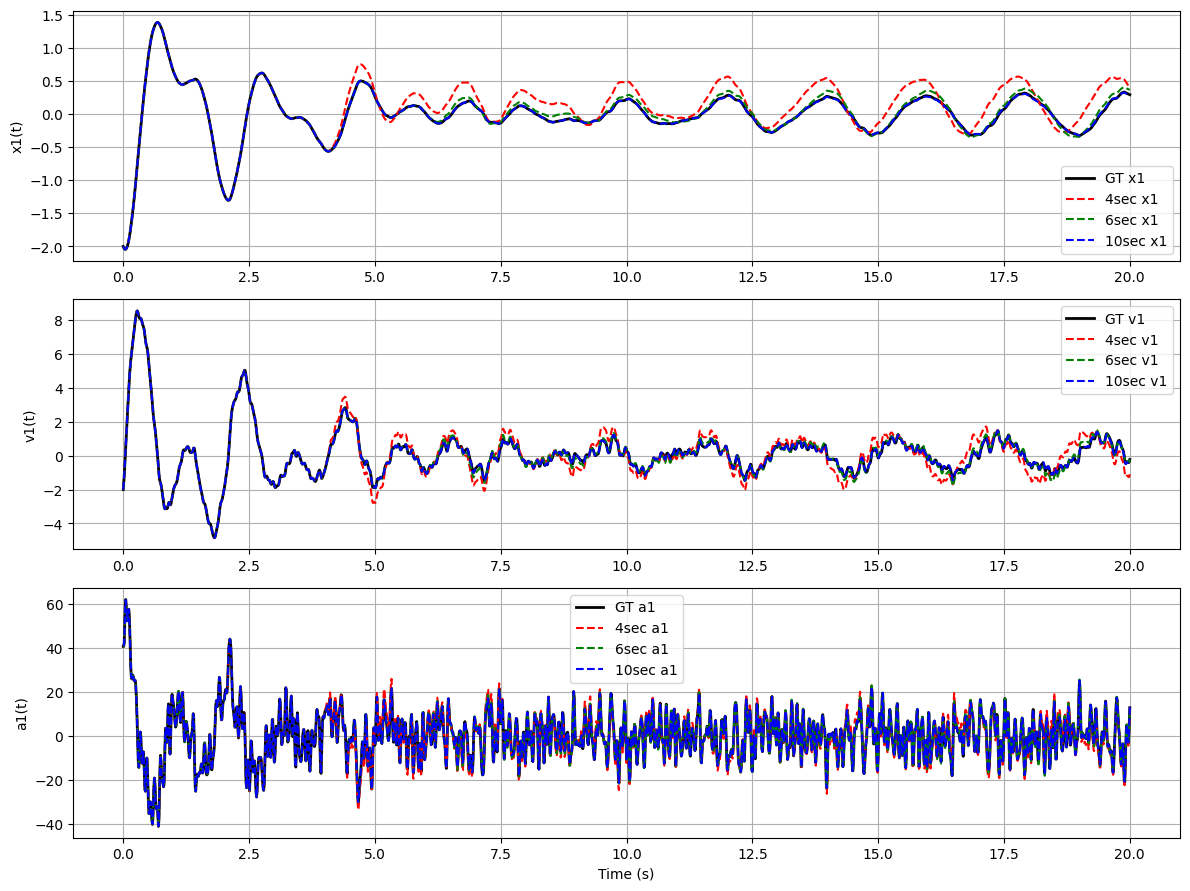

In [12]:
# traj_gt = traj_list[3]
amp_test = 10.0
traj_gt = generate_trajectory(h0_train[0], t_test, amp_test, u_base_fun)

# Scheme 3
model3_10 = PINODEFuncScheme3(K, C, B_force)
model3_10.load_state_dict(torch.load(save_path + "scheme_3_white_noise_exp2_h0_2_10sec_sloss_low.pth", map_location=device))

# Scheme 3
model3_4 = PINODEFuncScheme3(K, C, B_force)
model3_4.load_state_dict(torch.load(save_path + "scheme_3_white_noise_exp2_h0_2_4sec_sloss_low.pth", map_location=device))

model3_6 = PINODEFuncScheme3(K, C, B_force)
model3_6.load_state_dict(torch.load(save_path + "scheme_3_white_noise_exp2_h0_2_6sec_sloss_low.pth", map_location=device))

save_plot_path = save_path + "scheme_3_white_noise_exp2_h0_2_low_4_6_10.png"

traj_gt = generate_trajectory(h0_train[0], t_test, amp_test, u_base_fun)


model3_10.amp = float(amp_test)
model3_10.u_fun = u_base_fun
model3_6.amp = float(amp_test)
model3_6.u_fun = u_base_fun
traj_pred_10 = odeint(model3_10, h0_train[0], t_test, method='rk4')
traj_pred_6 = odeint(model3_6, h0_train[0], t_test, method='rk4')
model3_4.amp = float(amp_test)
model3_4.u_fun = u_base_fun
traj_pred_4 = odeint(model3_4, h0_train[0], t_test, method='rk4')

# plot_x1_v1_a1(t_test, traj_gt, traj_pred_10, dt=0.01)

plot_x1_v1_a1_three_preds(t_test, traj_gt, traj_pred_4, traj_pred_6, traj_pred_10, dt=0.01, label1="4sec",label2="6sec",label3="10sec",save_path=save_plot_path)


In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_three_loss_histories(loss_hist1,loss_hist2,loss_hist3,label1="Model 1",label2="Model 2",label3="Model 3",save_path=None,log_y=True,):

    epochs1 = loss_hist1[:, 0]
    losses1 = loss_hist1[:, 1]

    epochs2 = loss_hist2[:, 0]
    losses2 = loss_hist2[:, 1]

    epochs3 = loss_hist3[:, 0]
    losses3 = loss_hist3[:, 1]

    plt.figure(figsize=(8, 5))
    plt.plot(epochs1, losses1, "k", label=label1)
    plt.plot(epochs2, losses2, "y--", label=label2)
    plt.plot(epochs3, losses3, "r", label=label3)

    plt.xlabel("Global epoch")
    plt.ylabel("Total loss")
    if log_y:
        plt.yscale("log")
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=250)

    plt.show()


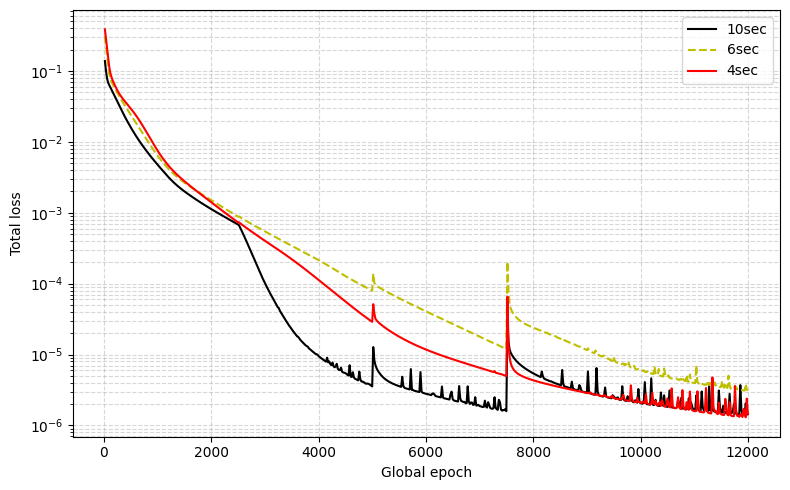

In [14]:
loss_log_path_10 = save_path + "scheme_3_white_noise_exp2_h0_2_10sec_sloss_low.npy"
loss_history_10 = np.load(loss_log_path_10)   # shape (N_logs, 2)

loss_log_path_6 = save_path + "scheme_3_white_noise_exp2_h0_2_6sec_sloss_low.npy"
loss_history_6 = np.load(loss_log_path_6)   # shape (N_logs, 2)

loss_log_path_4 = save_path + "scheme_3_white_noise_exp2_h0_2_4sec_sloss_low.npy"
loss_history_4 = np.load(loss_log_path_4)   # shape (N_logs, 2)

save_path_loss = save_path + "losses.png"

plot_three_loss_histories(loss_history_10, loss_history_6, loss_history_4, label1 = "10sec", label2 = "6sec",label3 = "4sec", save_path=save_path_loss )

In [15]:
pip install pysindy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4


In [16]:
import pysindy as ps

def build_sindy_discrepancy_exp2(h_true_list,amp_list,scheme,K_true,C_true,k_nl_true,B_force,t_grid,u_fun,device="cpu"):

    K = K_true.to(device)
    C = C_true.to(device)
    B = B_force.to(device)
    t_grid = t_grid.to(device)

    X_list = []
    Y_list = []

    for traj, amp in zip(h_true_list, amp_list):
        h_true = traj.to(device)   # (T,8)
        x = h_true[:, :4]
        v = h_true[:, 4:]

        # discrepancy for this trajectory & amplitude
        a_disc = discrepancy_reference(x, v, t_grid, scheme, K, C, k_nl_true, B, amp, u_fun)  # (T,4)

        X_list.append(h_true)
        Y_list.append(a_disc)

    X_all = torch.cat(X_list, dim=0)
    Y_all = torch.cat(Y_list, dim=0)

    X = X_all.cpu().numpy()  # (N,8)
    Y = Y_all.cpu().numpy()  # (N,4)

    return X, Y


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [17]:
def run_sindy_discrepancy_exp2(h_true_list,amp_list,scheme,K_true,C_true,k_nl_true,B_force,t_grid, u_fun,dt,threshold=0.05,device="cpu"):

    # Build data
    X, Y = build_sindy_discrepancy_exp2(h_true_list=h_true_list,amp_list=amp_list,scheme=scheme,K_true=K_true,C_true=C_true,k_nl_true=k_nl_true,B_force=B_force,t_grid=t_grid,u_fun=u_fun,device=device)
    # X: (N,8) state h = [x1..x4, v1..v4]
    # Y: (N,4) discrepancy accelerations

    # Polynomial library (like before)
    poly_lib = ps.PolynomialLibrary(degree=3,include_interaction=False,include_bias=False)

    # Optimizer
    optimizer = ps.STLSQ(threshold=threshold, alpha=1e-5, max_iter=100)

    # Fit 4 independent SINDy models, one per DOF discrepancy
    print(f"\n===== SINDy discrepancy equations for Scheme {scheme} (Experiment 2) =====")

    feature_names = ['x1','x2','x3','x4','v1','v2','v3','v4']

    for i in range(4):
        y_i = Y[:, i:i+1]   # (N,1)

        model = ps.SINDy(feature_library=poly_lib,optimizer=optimizer,)
        model.fit(X, t=dt, x_dot=y_i)

        coeffs = model.coefficients()[0]
        feats  = model.get_feature_names()

        print(f"\n--- dv{i+1}_disc ---")
        terms = []
        for c, term in zip(coeffs, feats):
            if abs(c) > 1e-9:
                terms.append(f"{c:+.5f} * {term}")
        if len(terms) == 0:
            print("   0")
        else:
            print("   dv{} = ".format(i+1) + " ".join(terms))


In [18]:
dt = 0.01

sindy_disc_s2 = run_sindy_discrepancy_exp2(h_true_list=traj_list,amp_list=amplitudes_train,scheme=3,K_true=K,C_true=C,k_nl_true=k_nl_true,B_force=B_force,t_grid=t_train,u_fun=u_base_fun,dt=dt,threshold=0.01,device=device)



===== SINDy discrepancy equations for Scheme 3 (Experiment 2) =====

--- dv1_disc ---
   dv1 = -2.00000 * x0^3

--- dv2_disc ---
   0

--- dv3_disc ---
   0

--- dv4_disc ---
   0


In [19]:
def build_sindy_discrepancy_from_nn_exp2(h_true_list, model, device="cpu"):

    # Concatenate all trajectories
    # h_true = torch.cat(h_true_list, dim=0).to(device)   # (N,8)

    with torch.no_grad():
        a_disc_nn = model.mlp(h_true_list)                   # (N,4)

    X = h_true_list.detach().cpu().numpy()
    Y = a_disc_nn.detach().cpu().numpy()

    return X, Y


In [55]:
import pysindy as ps

def run_sindy_discrepancy_from_nn_exp2(h_true_list,model,dt,threshold=0.01,device="cpu", t_train=t_train, t_test=t_test):


    # 1) Build X,Y from the trained neural net
    X, Y = build_sindy_discrepancy_from_nn_exp2(h_true_list=h_true_list,model=model,device=device)

    # 2) Same polynomial library as remainder of your code
    poly_lib = ps.PolynomialLibrary(degree=3,include_interaction=False,include_bias=False)

    # 3) Sparse optimizer
    optimizer = ps.STLSQ(threshold=threshold, alpha=1e-5, max_iter=1000)

    print(f"\n===== SINDy discrepancy equations for model trained in {t_train} second in {t_test} seconds using the elcentro groundtruth acceleration as excitation =====")

    sindy_models = []
    for i in range(4):
        y_i = Y[:, i:i+1]   # column i

        model_sindy = ps.SINDy(feature_library=poly_lib,optimizer=optimizer,)

        # Fit SINDy using NN-produced derivative y_i
        model_sindy.fit(X, t=dt, x_dot=y_i)
        sindy_models.append(model_sindy)

        coeffs = model_sindy.coefficients()[0]
        feats  = model_sindy.get_feature_names()

        print(f"\n--- dv{i+1}_disc (NN) ---")
        terms = []
        for c, term in zip(coeffs, feats):
            if abs(c) > 1e-9:
                terms.append(f"{c:+.5f} * {term}")
        if not terms:
            print("   0")
        else:
            print("   dv{} = ".format(i+1) + " ".join(terms))

    return sindy_models


In [43]:
t_train_test_end = 20.0

t_train_test = torch.linspace(0.0, t_train_test_end, int(t_train_end / dt) + 1, device=device)

traj_test = generate_trajectory(h0_train[0], t_train_test, amp_test, u_base_fun)

model3_4.amp = amp_test
model3_6.amp = amp_test
model3_10.amp = amp_test

pred_test4 = odeint(model3_4, h0_train[0], t_train_test)
pred_test6 = odeint(model3_6, h0_train[0], t_train_test)
pred_test10 = odeint(model3_10, h0_train[0], t_train_test)


In [41]:
models_s3_nn = run_sindy_discrepancy_from_nn_exp2(h_true_list=pred_test10,model=model3_10,dt=dt,threshold=0.05, device=device, t_train = 10.0, t_test = t_train_test_end)


===== SINDy discrepancy equations for model trained in 10.0 second in 20.0 seconds =====

--- dv1_disc (NN) ---
   dv1 = -2.00551 * x0^3

--- dv2_disc (NN) ---
   0

--- dv3_disc (NN) ---
   0

--- dv4_disc (NN) ---
   0


/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(


In [44]:
torch.manual_seed(0)

num_freqs = 70
freqs  = torch.linspace(0.5, 30.0, num_freqs, device=device)
phases = 2.0 * math.pi * torch.rand(num_freqs, device=device)
coeffs = torch.randn(num_freqs, device=device) / math.sqrt(num_freqs)

def u_fun_cos(t):
    t = t.to(device)
    t_exp = t.unsqueeze(-1)
    arg = 2.0 * math.pi * freqs * t_exp + phases
    return (coeffs * torch.cos(arg)).sum(dim=-1)


In [46]:
# Example: use IC 0 and amplitude 10.0 -> last amplitude of training
amp_test = 10
h0 = h0_train[0]
dt = 0.01
t_test_end = 20
t_test  = torch.linspace(0.0, t_test_end,  int(t_test_end  / dt) + 1, device=device)

# GT RHS with the new noise
rhs_test = make_ground_truth_rhs(amp_test, u_fun_cos)

# generate GT trajectory
gt_test = odeint(rhs_test, h0, t_test)   # (T, 8)



In [47]:
model3_4.u_fun = u_fun_cos     # assign the new forcing to the model
model3_4.amp   = amp_test       # same amplitude as GT
pred_test4 = odeint(model3_4, h0, t_test, method="rk4")
model3_6.u_fun = u_fun_cos     # assign the new forcing to the model
model3_6.amp   = amp_test       # same amplitude as GT
pred_test6 = odeint(model3_6, h0, t_test, method="rk4")
model3_10.u_fun = u_fun_cos     # assign the new forcing to the model
model3_10.amp   = amp_test       # same amplitude as GT
pred_test10 = odeint(model3_10, h0, t_test, method="rk4")


In [48]:
# Displacement x1
x1_gt   = gt_test[:, 0].detach().cpu().numpy()
x1_pred4 = pred_test4[:, 0].detach().cpu().numpy()
x1_pred6 = pred_test6[:, 0].detach().cpu().numpy()
x1_pred10 = pred_test10[:, 0].detach().cpu().numpy()

# Velocity v1
v1_gt   = gt_test[:, 4].detach().cpu().numpy()
v1_pred4 = pred_test4[:, 4].detach().cpu().numpy()
v1_pred6 = pred_test6[:, 4].detach().cpu().numpy()
v1_pred10 = pred_test10[:, 4].detach().cpu().numpy()

t_np = t_test.detach().cpu().numpy()



In [49]:
a1_gt_list   = []
a1_pred4_list = []
a1_pred6_list = []
a1_pred10_list = []

with torch.no_grad():
    # ground-truth rhs for this amp + forcing
    rhs_gt = make_ground_truth_rhs(amp_test, u_fun_cos)

    for k, t_k in enumerate(t_test):
        # GT acceleration
        dh_gt   = rhs_gt(t_k, gt_test[k])     # (8,)
        a1_gt   = dh_gt[4]                    # index 4 = a1
        a1_gt_list.append(a1_gt.item())

        # Model acceleration
        dh_pred4 = model3_4(t_k, pred_test4[k])   # (8,)
        a1_pred4 = dh_pred4[4]                  # index 4 = a1
        a1_pred4_list.append(a1_pred4.item())

        dh_pred6 = model3_6(t_k, pred_test6[k])   # (8,)
        a1_pred6 = dh_pred6[4]                  # index 4 = a1
        a1_pred6_list.append(a1_pred6.item())

        dh_pred10 = model3_10(t_k, pred_test10[k])   # (8,)
        a1_pred10 = dh_pred10[4]                  # index 4 = a1
        a1_pred10_list.append(a1_pred10.item())

a1_gt   = np.array(a1_gt_list)
a1_pred4 = np.array(a1_pred4_list)
a1_pred6 = np.array(a1_pred6_list)
a1_pred10 = np.array(a1_pred10_list)


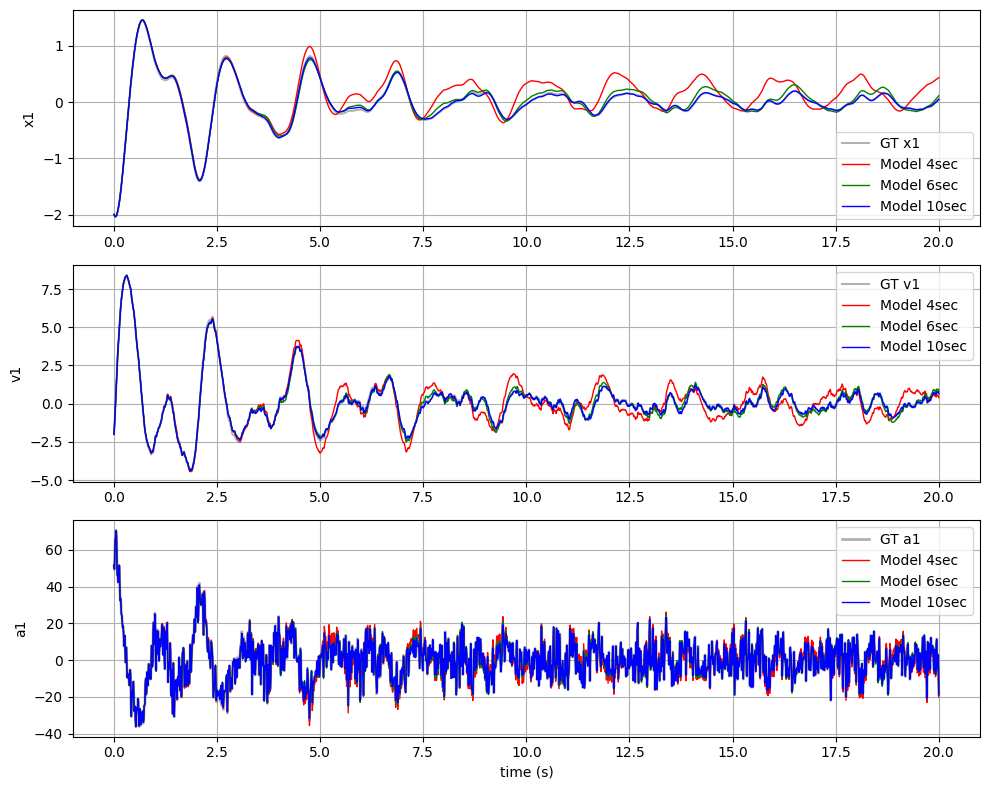

In [50]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))

# x1
plt.subplot(3, 1, 1)
plt.plot(t_np, x1_gt,    label="GT x1",   alpha=0.3, color='k')
plt.plot(t_np, x1_pred4, label="Model 4sec",  lw=1, color='r')
plt.plot(t_np, x1_pred6, label="Model 6sec",  lw=1, color='g')
plt.plot(t_np, x1_pred10,label="Model 10sec", lw=1, color='b')
plt.ylabel("x1")
plt.grid(True)
plt.legend()

# v1
plt.subplot(3, 1, 2)
plt.plot(t_np, v1_gt,    label="GT v1",   alpha=0.3, color='k')
plt.plot(t_np, v1_pred4, label="Model 4sec",  lw=1, color='r')
plt.plot(t_np, v1_pred6, label="Model 6sec",  lw=1, color='g')
plt.plot(t_np, v1_pred10,label="Model 10sec", lw=1, color='b')
plt.ylabel("v1")
plt.grid(True)
plt.legend()

# a1
plt.subplot(3, 1, 3)
plt.plot(t_np, a1_gt,    label="GT a1",   alpha=0.3, lw=2, color='k')
plt.plot(t_np, a1_pred4, label="Model 4sec",  lw=1, color='r')
plt.plot(t_np, a1_pred6, label="Model 6sec",  lw=1, color='g')
plt.plot(t_np, a1_pred10,label="Model 10sec", lw=1, color='b')
plt.xlabel("time (s)")
plt.ylabel("a1")
plt.grid(True)
plt.legend()


save_plot_path = save_path + "scheme_3_white_noise_exp2_h0_2_low_4_6_10_diff_fun.png"
fig.tight_layout()
fig.savefig(save_plot_path, dpi=300, bbox_inches="tight")
plt.show()



In [54]:
models_s3_nn = run_sindy_discrepancy_from_nn_exp2(h_true_list=pred_test10,model=model3_10,dt=dt,threshold=0.5, t_train = 10.0, t_test = t_test_end, device=device)


===== SINDy discrepancy equations for model trained in 10.0 second in 20 seconds using a different excitation =====

--- dv1_disc (NN) ---
   dv1 = -1.92792 * x0^3

--- dv2_disc (NN) ---
   0

--- dv3_disc (NN) ---
   0

--- dv4_disc (NN) ---
   0


/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(


In [57]:
import numpy as np
import torch

data = np.loadtxt("/content/drive/MyDrive/elcentro.dat")

dt_ec = 0.02  # time step 0.02s

if data.ndim == 1:
    acc_ec = data # if it has one column, we assume that it represents the ground acceleration
    t_ec = np.arange(len(acc_ec)) * dt_ec # time is constructed
else:
    t_ec = data[:, 0]
    acc_ec = data[:, 1]

# acc_ec = -acc_ec

t_ec_torch   = torch.tensor(t_ec,    dtype=torch.float32, device=device)
acc_ec_torch = torch.tensor(acc_ec,  dtype=torch.float32, device=device)


# build a continuous time forcing function
def make_timeseries_fun(t_vec, u_vec):
    dt = (t_vec[1] - t_vec[0]).item() # dt
    t0 = t_vec[0].item() # first time recording
    t_end = t_vec[-1].item() # last time recording
    N  = t_vec.numel() # number of time samples

    def u_fun(t): # this function will be called by odeint during integration.
        if t > t_end: # check
            return torch.tensor(0.0, device=t.device, dtype=u_vec.dtype)
        idx = ((t - t0) / dt).long() # maps to nearest sample
        idx = torch.clamp(idx, 0, N - 1) # force time to be inside the bounds
        return u_vec[idx]
    return u_fun

u_fun_elcentro = make_timeseries_fun(t_ec_torch, acc_ec_torch)


In [58]:
# Use the same dt and horizon as the record
t_test_end = 40
t_test  = torch.linspace(0.0, t_test_end,  int(t_test_end  / dt_ec) + 1, device=device)
h0 = h0_train[0]                        # since model3 was trained on this IC
amp_test = 10                 # or any scalar scaling you want

# Ground-truth trajectory under El Centro forcing
rhs_test = make_ground_truth_rhs(amp_test, u_fun_elcentro)
gt_test  = odeint(rhs_test, h0, t_test, method="rk4")   # (T, 8)

# Model prediction under the same forcing
model3_10.u_fun = u_fun_elcentro
model3_10.amp   = amp_test
pred_test_10 = odeint(model3_10, h0, t_test, method="rk4")

# Model prediction under the same forcing
model3_6.u_fun = u_fun_elcentro
model3_6.amp   = amp_test
pred_test_6 = odeint(model3_6, h0, t_test, method="rk4")

# Model prediction under the same forcing
model3_4.u_fun = u_fun_elcentro
model3_4.amp   = amp_test
pred_test_4 = odeint(model3_4, h0, t_test, method="rk4")


In [59]:
import numpy as np

# 1) time
t_np = t_test.detach().cpu().numpy()

# 2) x1, v1
x1_gt   = gt_test[:, 0].detach().cpu().numpy()
x1_pred4 = pred_test_4[:, 0].detach().cpu().numpy()
x1_pred6 = pred_test_6[:, 0].detach().cpu().numpy()
x1_pred10 = pred_test_10[:, 0].detach().cpu().numpy()

v1_gt   = gt_test[:, 4].detach().cpu().numpy()
v1_pred4 = pred_test_4[:, 4].detach().cpu().numpy()
v1_pred6 = pred_test_6[:, 4].detach().cpu().numpy()
v1_pred10 = pred_test_10[:, 4].detach().cpu().numpy()

# 3) a1 via RHS
a1_gt_list   = []
a1_pred4_list = []
a1_pred6_list = []
a1_pred10_list = []

with torch.no_grad():
    rhs_gt = make_ground_truth_rhs(amp_test, u_fun_elcentro)

    for k, t_k in enumerate(t_test):
        dh_gt   = rhs_gt(t_k, gt_test[k])
        a1_gt_list.append(dh_gt[4].item())

        dh_pred4 = model3_4(t_k, pred_test_4[k])
        a1_pred4_list.append(dh_pred4[4].item())

        dh_pred6 = model3_6(t_k, pred_test_6[k])
        a1_pred6_list.append(dh_pred6[4].item())

        dh_pred10 = model3_10(t_k, pred_test_10[k])
        a1_pred10_list.append(dh_pred10[4].item())

a1_gt   = np.array(a1_gt_list)
a1_pred4 = np.array(a1_pred4_list)
a1_pred6 = np.array(a1_pred6_list)
a1_pred10 = np.array(a1_pred10_list)


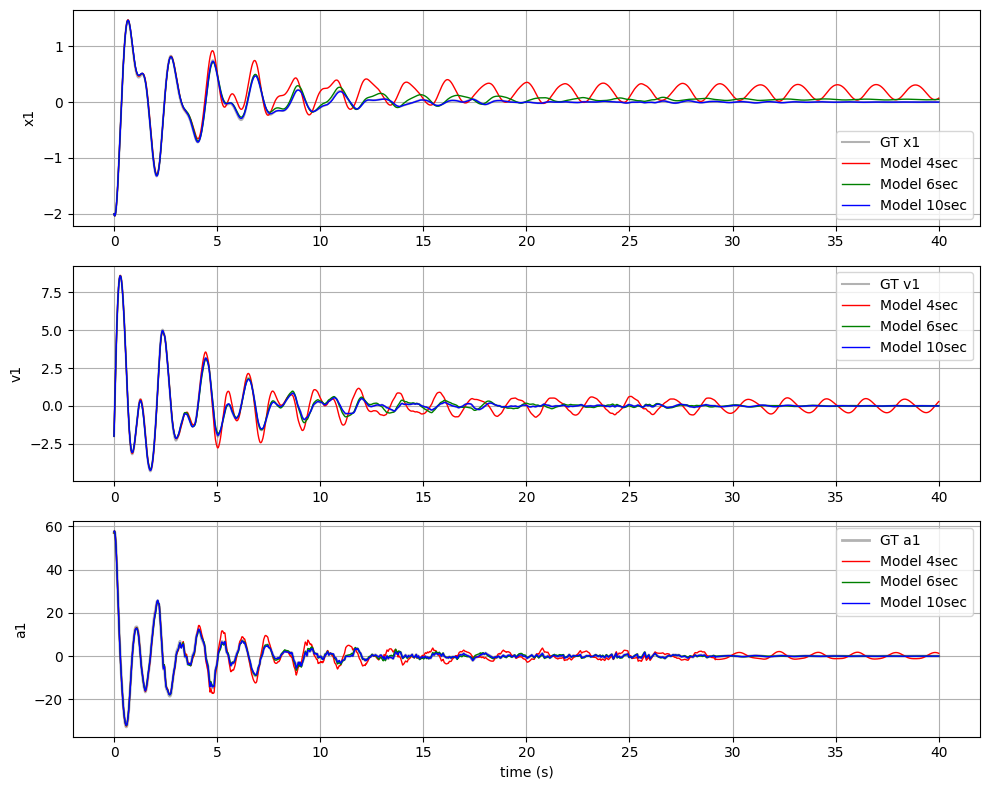

In [60]:
fig = plt.figure(figsize=(10, 8))

# x1
plt.subplot(3, 1, 1)
plt.plot(t_np, x1_gt,    label="GT x1",   alpha=0.3, color='k')
plt.plot(t_np, x1_pred4, label="Model 4sec",  lw=1, color='r')
plt.plot(t_np, x1_pred6, label="Model 6sec",  lw=1, color='g')
plt.plot(t_np, x1_pred10,label="Model 10sec", lw=1, color='b')
plt.ylabel("x1")
plt.grid(True)
plt.legend()

# v1
plt.subplot(3, 1, 2)
plt.plot(t_np, v1_gt,    label="GT v1",   alpha=0.3, color='k')
plt.plot(t_np, v1_pred4, label="Model 4sec",  lw=1, color='r')
plt.plot(t_np, v1_pred6, label="Model 6sec",  lw=1, color='g')
plt.plot(t_np, v1_pred10,label="Model 10sec", lw=1, color='b')
plt.ylabel("v1")
plt.grid(True)
plt.legend()

# a1
plt.subplot(3, 1, 3)
plt.plot(t_np, a1_gt,    label="GT a1",   alpha=0.3, lw=2, color='k')
plt.plot(t_np, a1_pred4, label="Model 4sec",  lw=1, color='r')
plt.plot(t_np, a1_pred6, label="Model 6sec",  lw=1, color='g')
plt.plot(t_np, a1_pred10,label="Model 10sec", lw=1, color='b')
plt.xlabel("time (s)")
plt.ylabel("a1")
plt.grid(True)
plt.legend()


save_plot_path = save_path + "scheme_3_white_noise_exp2_h0_2_low_4_6_10_elcentro.png"
fig.tight_layout()
fig.savefig(save_plot_path, dpi=300, bbox_inches="tight")
plt.show()


In [63]:
models_s3_nn = run_sindy_discrepancy_from_nn_exp2(h_true_list=pred_test_10,model=model3_10,dt=dt,threshold=0.5, t_train = 10.0, t_test = t_test_end, device=device)


===== SINDy discrepancy equations for model trained in 10.0 second in 40 seconds using the elcentro groundtruth acceleration as excitation =====

--- dv1_disc (NN) ---
   dv1 = -1.94684 * x0^3

--- dv2_disc (NN) ---
   0

--- dv3_disc (NN) ---
   0

--- dv4_disc (NN) ---
   0


/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(
